In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [6]:
# Load data
train_set = pd.read_csv("train_cleandata.csv")
test_set = pd.read_csv("test_cleandata.csv")

# Convert categorical variables to categorical dtype
categorical_cols = ["quarter", "day", "team", "department"]
train_set[categorical_cols] = train_set[categorical_cols].astype("category")
test_set[categorical_cols] = test_set[categorical_cols].astype("category")

# Define predictors
department_predictors = [
    "targeted_productivity", "smv", "wip", "over_time", "incentive",
    "idle_time", "idle_men", "no_of_style_change", "no_of_workers",
    "quarter", "day", "team"
]

overall_predictors = department_predictors + ["department"]

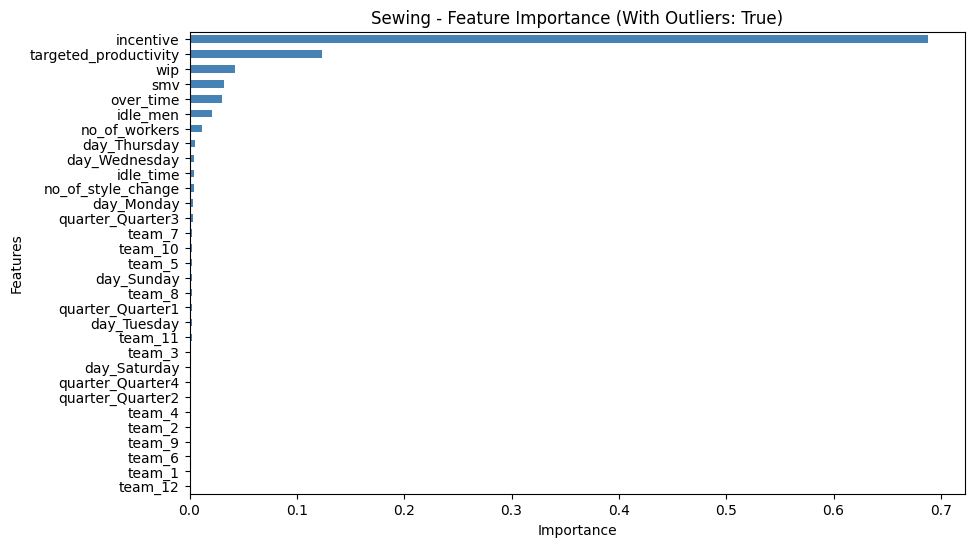

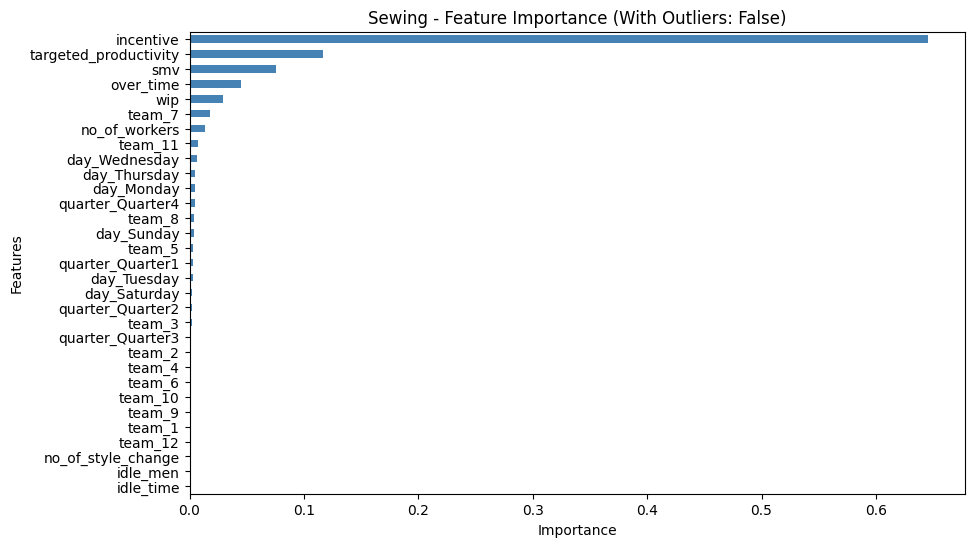

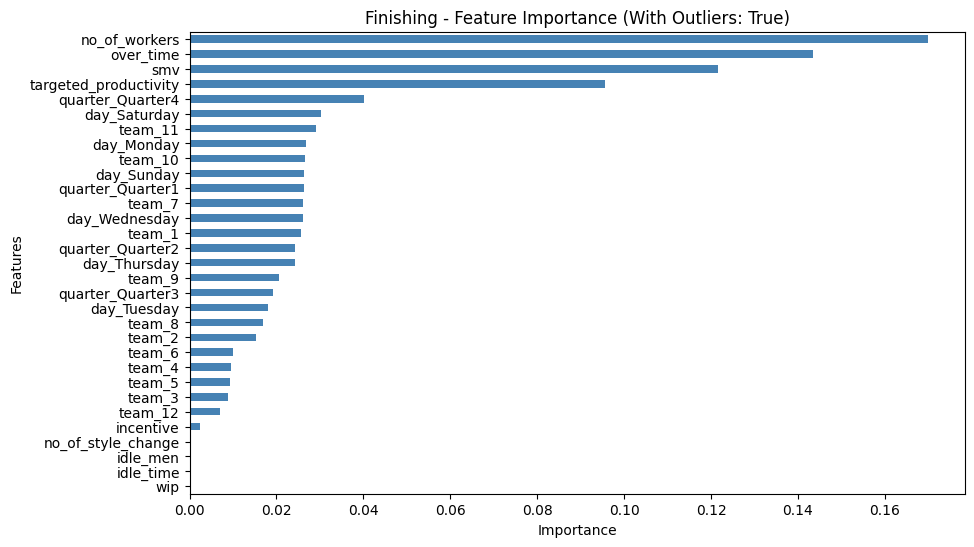

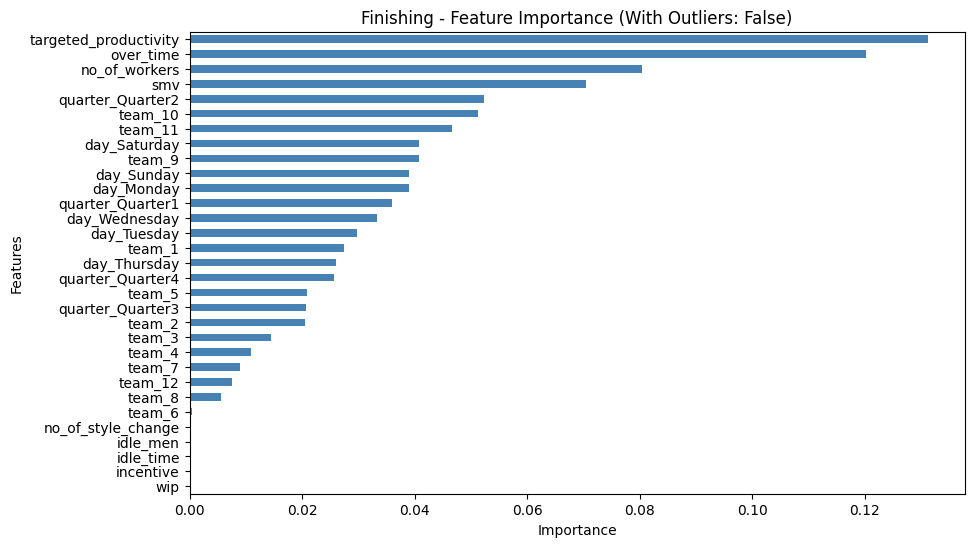

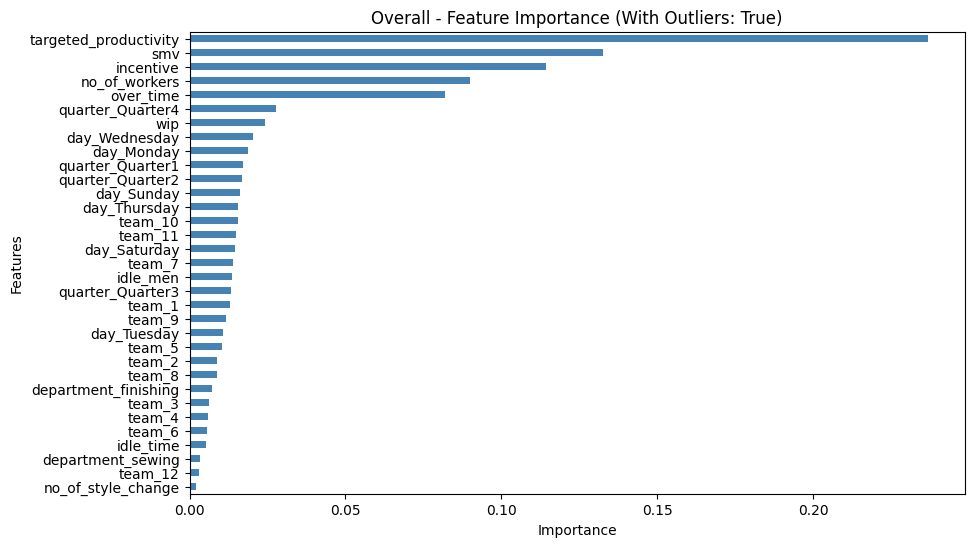

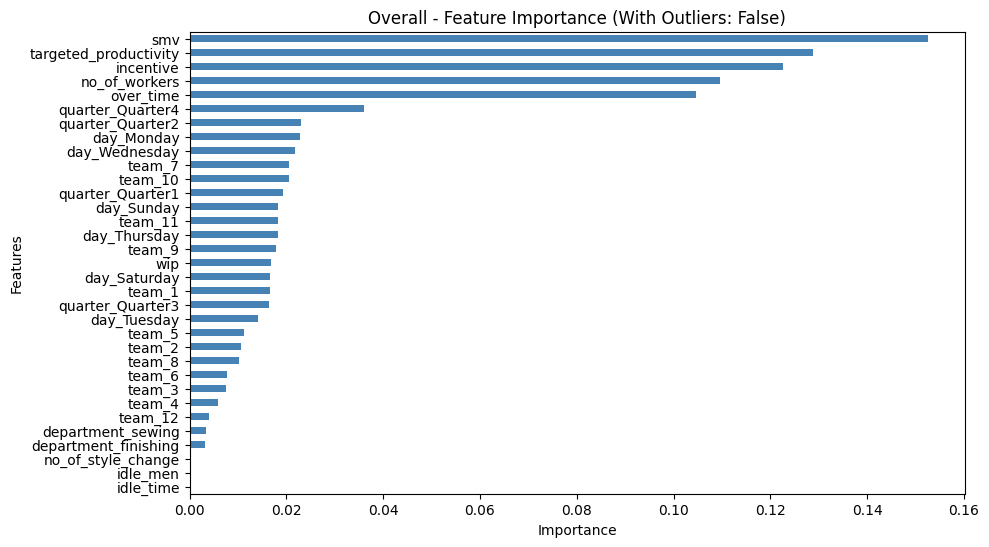

              Train MSE            Test MSE            Train R²            \
With Outliers     False     True      False     True      False     True    
Department                                                                  
Finishing      0.004222  0.004471  0.027056  0.027485  0.873927  0.884282   
Overall        0.002488  0.002292  0.011794  0.012819  0.907458  0.925827   
Sewing         0.000343  0.000655  0.002844  0.004600  0.967733  0.973416   

                Test R²            
With Outliers     False     True   
Department                         
Finishing      0.014655  0.214655  
Overall        0.488929  0.514962  
Sewing         0.686865  0.776445  


In [7]:
def handle_outliers(data, numerical_cols):
    """Remove outliers using IQR method"""
    filtered_data = data.copy()
    for col in numerical_cols:
        Q1 = filtered_data[col].quantile(0.25)
        Q3 = filtered_data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        filtered_data = filtered_data[
            (filtered_data[col] >= lower_bound) & 
            (filtered_data[col] <= upper_bound)
        ]
    return filtered_data

def train_evaluate_rf(train_data, test_data, department_name, predictors, with_outliers=True):
    # Copy data to avoid modifying original
    train = train_data.copy()
    test = test_data.copy()

    # Identify numerical columns from predictors
    numerical_cols = train[predictors].select_dtypes(include=np.number).columns.tolist()
    
    # Handle outliers
    if not with_outliers:
        train = handle_outliers(train, numerical_cols)
        test = handle_outliers(test, numerical_cols)

    # Prepare data
    X_train = train[predictors]
    X_test = test[predictors]
    y_train = train["actual_productivity"]
    y_test = test["actual_productivity"]

    # One-hot encode categorical variables
    X_train = pd.get_dummies(X_train)
    X_test = pd.get_dummies(X_test)
    
    # Align test columns with train columns
    X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

    # Train model
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Feature importance
    importance = pd.Series(model.feature_importances_, index=X_train.columns)
    importance = importance.sort_values(ascending=True)
    
    plt.figure(figsize=(10, 6))
    importance.plot(kind='barh', color='steelblue')
    plt.xlabel("Importance")
    plt.ylabel("Features")
    plt.title(f"{department_name} - Feature Importance (With Outliers: {with_outliers})")
    plt.show()

    # Predictions and metrics
    metrics = {
        "with_outliers": with_outliers,
        "train_mse": mean_squared_error(y_train, model.predict(X_train)),
        "test_mse": mean_squared_error(y_test, model.predict(X_test)),
        "train_r2": r2_score(y_train, model.predict(X_train)),
        "test_r2": r2_score(y_test, model.predict(X_test))
    }
    
    return metrics

# Department-wise data preparation
sewing_train = train_set[train_set["department"] == "sewing"]
sewing_test = test_set[test_set["department"] == "sewing"]
finishing_train = train_set[train_set["department"] == "finishing"]
finishing_test = test_set[test_set["department"] == "finishing"]

# Store results
results = []

# Process for each department
for dept_name, train, test in [
    ("Sewing", sewing_train, sewing_test),
    ("Finishing", finishing_train, finishing_test),
    ("Overall", train_set, test_set)
]:
    # Get appropriate predictors
    predictors = overall_predictors if dept_name == "Overall" else department_predictors
    
    # Run with and without outliers
    for outlier_setting in [True, False]:
        metrics = train_evaluate_rf(
            train, test, dept_name, predictors, with_outliers=outlier_setting
        )
        results.append({
            "Department": dept_name,
            "With Outliers": outlier_setting,
            "Train MSE": metrics["train_mse"],
            "Test MSE": metrics["test_mse"],
            "Train R²": metrics["train_r2"],
            "Test R²": metrics["test_r2"]
        })

# Display results
results_df = pd.DataFrame(results)
print(results_df.pivot(index="Department", columns="With Outliers"))